In [1]:
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Sample false positives load from txt file where separated by newline
with open("scripts/output/false_positives.txt", "r") as file:
    fp_list = file.read().splitlines()
    false_positives = [eval(val)[0] for val in fp_list]
    fp_repos = [eval(val)[1] for val in fp_list]
len(false_positives),len(fp_repos)

(8787, 8787)

In [3]:
 # Define regex patterns for repositories
repo_patterns = {
    'PRIDE': r'^pxd\d{6}$|^pdx\d{6}$',
    'MassIVE': r'^msv\d+$|^msv\d{6}$|^mz\d+$',
    'GEO': r'^gse\d+$',
    'GSM': r'^gsm\d+$',
    'GPL': r'^gpl\d+$',
    'EGA': r'^egad\d+$|^egas\d+$|^ega-box-\d+|^egac\d+$',
    'dbGaP': r'^phs\d+',
    'BioSample': r'^samn\d+$',
    'BioProject': r'^prjna\d+$|^prjeb\d+$|^prjdb\d+$|^prjda\d+$|^pr\d+$|^prjca\d+$',
    'SRA': r'^srp\d+$|^srr\d+$|^srx\d+$|^sra\d+$|^dr[a-z]\d+$|^erp\d+$|^srs\d+$|^err\d+$',
    'ENA': r'^ers\d+$|^erp\d+$|^era\d+$',
    'JPOST': r'^jpst\d+$|^jpost:jpst\d+$',
    'PDB': r'^(pdb\s*[:\-]?\s*)?\w{4}$|^pdbdev_\d{9}$',
    'EMDB': r'^emd[-_]?\d+$|^empiar[-_]?\d+$',
    'IPROX': r'^ipx\d+$|^ipx\d{10}$',
    'MetaboLights': r'^mtbls\d+$|^st\d+$',
    'Metabolomics Workbench': r'^st\d+$|^metabolomics workbench',
    'ArrayExpress': r'^e-\w+-\d+$|^emtab\d+$',
    'Human Cell Atlas': r'^hra\d+$',
    'NBDC Japan': r'^jd\d+$|^jga\d+$',
    'NIHMS': r'^nihms\d+$',
    'PMC': r'^pmc\d+$',
    'PubMed': r'^\d{7,9}$',
    'BMRB': r'^bmrb\s*\d+$',
    'EMPIAR': r'^empiar[-_]?\d+$',
    'Cell Image Library': r'^c[0-9a-z]{6,}$',
    'Zenodo': r'zenodo|doi.org/10\.5281/zenodo\.\d+|10\.5281/zenodo\.\d+',
    'Dryad': r'dryad|10\.\d+/dryad\.\w+',
    'Figshare': r'figshare|10\.\d{4,9}/figshare\.\d+',
    'GitHub': r'^https?://github\.com/',
    'Salk Institute': r'^salk_\d+$',
    'ENCODE': r'^wgencode.*|^encitp.*|^encsr\d+$|^encff\d+$|^encdo\d+$',
    'Gene Expression Omnibus': r'^gsm\d+$|^gse\d+$',
    'Genome Data Viewer': r'^cp\d+',
    'ClinVar': r'^scv\d+$|^vcv\d+\.\d+$',
    'GVM': r'^gvm\d+$',
    'OSU Repository': r'^osu-',
    'DDBJ': r'^dra\d+$|^drr\d+$',
    'JGA Japan': r'^jga\d+$',
    'EV-Repo': r'^ev\d+',
    'Synapse': r'^syn\d{7,12}$',
    'Clinical Trials': r'^nct\d{8}$',
    'GenBank': r'^[a-z]{1,2}\d{5,6}(\.\d+)?$|^[a-z]{2}_\d{6,9}(\.\d+)?$',
    'RefSeq': r'^n[mprw]_\d{6,9}(\.\d+)?$|^xm_\d{6,9}(\.\d+)?$|^np_\d{6,9}(\.\d+)?$',
    'UniProt': r'^[a-z]\d[a-z0-9]{3}\d$|^[opq]\d[a-z0-9]{3}\d$',
    'GWAS Catalog': r'^gcst\d{5,9}$',
    'dbSNP': r'^rs\d+$',
    'TCGA': r'^tcga-[a-z]{2,5}$|^tcga[a-z]$',
    'CPTAC': r'^cptac',
    'BrATS': r'^brats\s*(201[5-9]|202[0-5])$|brats\s*201[5-9]|brats\s*202[0-5]',
    'IEU OpenGWAS': r'^ieu-[ab]-\d+$|^ukb-[abd]-\d+$|^finn-[ab]-',
    'COSMIC': r'^cosmic$',
    'GTEX': r'^gtex',
    'Mouse Genome Database': r'^mgi$',
    'JAX Mice': r'^jax\s*#?\d{6}$|^\d{6}$',
    'FinnGen': r'^finn-[ab]-|^finngen',
    'UK Biobank': r'^ukb[ab]?-[abd]?-?\d+$',
    'HumanCellAtlas': r'^scp\d{3,4}$',
    'ImmPort': r'^sdy\d+$',
    'BioGRID': r'^biogrid$',
    'KEGG': r'^hsa\d+$|^kegg$',
    'MSigDB': r'^msigdb$|^c\d\.|^hallmarks$',
    'Reactome': r'^reactome$',
    '4DN': r'^4dn[a-z]\w+$',
    'CellLines': r'^cvcl_[a-z0-9]+$|^crl-\d+$',
    'ROSMAP': r'^rosmap$',
    'LINCS': r'^lincs$',
    'ProteinAtlas': r'^hpa$',
    'ChEMBL': r'^chembl$',
    'DrugBank': r'^drugbank$',
    'NHGRI-EBI GWAS': r'^ebi-a-gcst\d+$',
    'OpenNeuro': r'^ds\d{6}$',
    'TCIA': r'^10\.7937/',
    'OpenTargets': r'^opentargets$',
    'STRING': r'^string$',
    'BioModels': r'^biomd\d+$',
    'OmicsDB': r'^omix\d+$',
    'PDC': r'^pdc\d{6}$',
    'PharmacoDB': r'^pharmacodb$',
    'DepMap': r'^depmap$',
    'CCLE': r'^ccle$',
    'Addgene': r'^addgene_\d+$',
    'RRID': r'^rrid:',
    'SwissModel': r'^swissmodel$',
    'PeptideAtlas': r'^pass\d+$',
    'CIDC': r'^cidc$'
}

# Classify false positives and count frequencies
repo_counts = defaultdict(int)

for fp, repo in zip(false_positives, fp_repos):
    classified = False
    
    if repo and repo != 'nan' and repo not in ['www.ncbi.nlm.nih.gov']:
        repo_counts[repo] += 1
        classified = True
        continue
    if repo == 'www.ncbi.nlm.nih.gov':
        repo_counts['pmc.ncbi.nlm.nih.gov'] += 1
        classified = True
        continue
    for repo, pattern in repo_patterns.items():
        if re.match(pattern, fp, re.IGNORECASE):
            repo_counts[repo] += 1
            classified = True
            break
    if not classified:
        print(f"Unmatched: {fp}")
        repo_counts['Other'] += 1

Unmatched: covidx
Unmatched: aiforcovid
Unmatched: imagenet
Unmatched: brats 2013
Unmatched: image:3870426
Unmatched: supplementary file1 (xlsx 5457 kb)
Unmatched: bypass40
Unmatched: giana 2021
Unmatched: nerthus
Unmatched: kvasir
Unmatched: instrument-kvasir
Unmatched: kvasir-seg
Unmatched: cvc-clinicdb
Unmatched: irrs0000100
Unmatched: chestx-ray8
Unmatched: image:3870426
Unmatched: flare2022
Unmatched: chaos
Unmatched: isic 2018
Unmatched: isbi2019 mri
Unmatched: kits 2019
Unmatched: lits 2017
Unmatched: ms-cmrseg
Unmatched: bcv
Unmatched: covid-ds36
Unmatched: amos22
Unmatched: divat
Unmatched: miccai 2015 ct
Unmatched: msd
Unmatched: thorax-85
Unmatched: kits 2021
Unmatched: brats21
Unmatched: kits19-m
Unmatched: encsr000cou
Unmatched: banner
Unmatched: wo2019-014618
Unmatched: fastmri+
Unmatched: braineac
Unmatched: codex
Unmatched: psychencode
Unmatched: msisensor.10k
Unmatched: amc-ajccii-90
Unmatched: msigdb v2023.2
Unmatched: v23
Unmatched: misaw
Unmatched: ensg00000256128
U

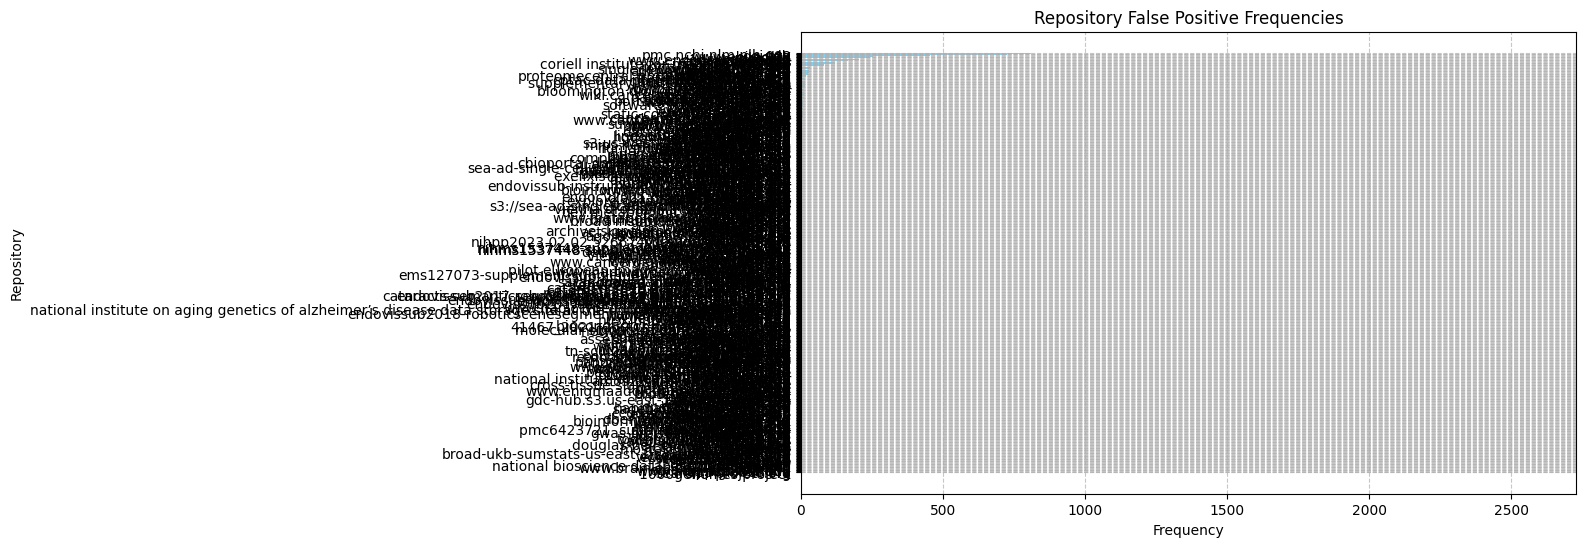

In [4]:
# Convert to DataFrame for display
repo_df = pd.DataFrame(list(repo_counts.items()), columns=['Repository', 'Frequency'])
repo_df.sort_values('Frequency', ascending=False, inplace=True)
# Display directly here# Plotting the frequencies
plt.figure(figsize=(10, 6))
plt.barh(repo_df['Repository'], repo_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Repository')
plt.title('Repository False Positive Frequencies')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [5]:
repo_df.to_csv("scripts/output/repo_false_positive_frequencies.csv", index=False)
repo_df

,Repository,Frequency
0,geo,2597
7,pmc.ncbi.nlm.nih.gov,810
3,doi.org,726
2,pdb,453
31,www.ebi.ac.uk,256
...,...,...
289,www.adni.loni.usc.edu,1
286,ftp.ncbi.nih.gov,1
285,app.globus.org,1
283,search.r-project.org,1


In [6]:
syn_missed_ids = []
for false_positive in false_positives:
    if re.match(repo_patterns['Synapse'], false_positive, re.IGNORECASE):
        syn_missed_ids.append(false_positive)
        print(f"Missed Synapse ID: {false_positive}")


Missed Synapse ID: syn51225253
Missed Synapse ID: syn51225257
Missed Synapse ID: syn51225260
Missed Synapse ID: syn3219018
Missed Synapse ID: syn26553019
Missed Synapse ID: syn3159438
Missed Synapse ID: syn26553018
Missed Synapse ID: syn10901594
Missed Synapse ID: syn10901606
Missed Synapse ID: syn2580853
Missed Synapse ID: syn3219045
Missed Synapse ID: syn2580853
Missed Synapse ID: syn18485175
Missed Synapse ID: syn53352733
Missed Synapse ID: syn21570779
Missed Synapse ID: syn2580853
Missed Synapse ID: syn27624812
Missed Synapse ID: syn3157293
Missed Synapse ID: syn5096262
Missed Synapse ID: syn23564903
Missed Synapse ID: syn7220556
Missed Synapse ID: syn2787215
Missed Synapse ID: syn64112114
Missed Synapse ID: syn11707420
Missed Synapse ID: syn4591751
Missed Synapse ID: syn4509334
Missed Synapse ID: syn4591895
Missed Synapse ID: syn4591761
Missed Synapse ID: syn4591754
Missed Synapse ID: syn4591893
Missed Synapse ID: syn4591889
Missed Synapse ID: syn4591887
Missed Synapse ID: syn4591

# Examples of Synapse IDs not spotted



### 1. `(synapse file ID syn:11707420)`

from `https://pmc.ncbi.nlm.nih.gov/articles/PMC11864243`



Data sources

The genomic variant data used in this study was obtained from the Accelerating Medicines Partnership - Alzheimer's Disease (AMP-AD) consortium. This dataset harmonizes whole-genome sequencing (WGS) data from three major Alzheimer's disease cohorts: the Religious Orders Study and Memory and Aging Project (ROSMAP), Mount Sinai Brain Bank (MSBB), and the Mayo RNA-seq (Mayo) study.35–38 The WGS data is available in VCF format from the Alzheimer's Disease Knowledge Portal (synapse file ID syn:11707420). Relevant covariate data, including diagnostic information and APOE genotypes, were sourced as CSV files for each cohort (MSBB: syn6101474, Mayo: syn23277389, ROSMAP: syn3191087).



### 2. `synapse.org/syn# 23564903`

from `https://pmc.ncbi.nlm.nih.gov/articles/PMC11602985/`

RNA-sequencing

The ROSMAP study provides RNA-Seq data from the dorsolateral prefrontal cortex (38). The Broad Institutes’ Genomics Platform performed RNA-Seq library preparation using the strand-specific dUTP method with poly-A selection (39). Sequencing was performed on the Illumina HiSeq. Quantile normalization method was applied to FPKM first and combat package was used to remove the potential batch effect. The ROS-MAP cortical RNA-Seq consolidated dataset is available directly from Research Resource Sharing Hub at https://www.radc.rush.edu/home.htm and at synapse.org/syn# 23564903. For APOB mRNA levels, we selected the full-length transcript ENST00000233242.

# Association Rule Mining for Dataset Co-occurrence

Now let's analyze which datasets (repositories) are frequently used together in the same papers. This can help identify common data integration patterns and suggest related datasets for researchers.

In [7]:
# First, let's load the full dataset results to get paper-level co-occurrence information
# We need to group datasets by paper (source_url) to find which datasets appear together

# Load the results data - adjust path as needed
try:
    # Try to load from the results file mentioned in the other notebook
    results_df = pd.read_csv('scripts/output/syn_data_results/result_gemini-2.5-flash_full-input.csv')
    print(f"Loaded {len(results_df)} dataset records")
    print(f"From {results_df['source_url'].nunique()} unique papers")
    
    # Show structure
    print("\nColumns:", results_df.columns.tolist())
    print("\nFirst few rows:")
    print(results_df[['source_url', 'dataset_identifier', 'data_repository']].head())
    
except FileNotFoundError:
    print("Results file not found. Please provide the correct path to your dataset results.")
    results_df = None

Loaded 23936 dataset records
From 2190 unique papers

Columns: ['dataset_identifier', 'data_repository', 'dataset_webpage', 'citation_type', 'access_mode', 'link', 'source_url', 'download_link', 'title', 'content_type', 'id', 'caption', 'description', 'source_section', 'retrieval_pattern', 'context_description', 'file_extension', 'pub_title', 'raw_data_format', 'file_info', 'section_class', 'a_attr_href', 'a_attr_class', 'a_attr_data-ga-action', 'a_attr_target', 'a_attr_rel']

First few rows:
                                          source_url dataset_identifier  \
0  https://pmc.ncbi.nlm.nih.gov/articles/PMC10001072          GSE193959   
1  https://pmc.ncbi.nlm.nih.gov/articles/PMC10001072          GSE149180   
2  https://pmc.ncbi.nlm.nih.gov/articles/PMC10001072          GSE138474   
3  https://pmc.ncbi.nlm.nih.gov/articles/PMC10001072        syn23630203   
4  https://pmc.ncbi.nlm.nih.gov/articles/PMC10001072                NaN   

           data_repository  
0                     

In [8]:
# Frequency of repositories in results_df 
# Use dataset identifier containing zenodo to disambiguate repository name doi.org to zenodo

repo_counts = defaultdict(int)

# Process each row to get both repository and dataset identifier
for idx, row in results_df.iterrows():
    repo = row['data_repository']
    dataset_id = str(row['dataset_identifier']).lower() if pd.notna(row['dataset_identifier']) else ''
    
    if repo and repo != 'nan' and repo not in ['www.ncbi.nlm.nih.gov', 'doi.org']:
        repo_counts[repo] += 1
    elif repo == 'www.ncbi.nlm.nih.gov':
        repo_counts['pmc.ncbi.nlm.nih.gov'] += 1
    elif repo == 'doi.org':
        # Use dataset identifier to disambiguate doi.org cases
        classified = False
        
        # Check for zenodo patterns in the dataset identifier
        if 'zenodo' in dataset_id or '10.5281/zenodo' in dataset_id:
            repo_counts['Zenodo'] += 1
            classified = True
        # Check for figshare patterns
        elif 'figshare' in dataset_id or 'figshare' in dataset_id:
            repo_counts['Figshare'] += 1
            classified = True
        # Check for dryad patterns
        elif 'dryad' in dataset_id:
            repo_counts['Dryad'] += 1
            classified = True
        else:
            # Try to match against other repository patterns using dataset identifier
            for repo_name, pattern in repo_patterns.items():
                if re.match(pattern, dataset_id, re.IGNORECASE):
                    repo_counts[repo_name] += 1
                    classified = True
                    break
        
        # If still not classified, keep as generic DOI
        if not classified:
            repo_counts['DOI (unclassified)'] += 1
    else:
        # Handle NaN or other cases
        repo_counts['Other/Unknown'] += 1

print(f"Total repository classifications: {sum(repo_counts.values())}")
print(f"Unique repositories found: {len(repo_counts)}")

# Show top repositories
sorted_repos = sorted(repo_counts.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 10 repositories:")
for i, (repo, count) in enumerate(sorted_repos[:10], 1):
    print(f"{i:2d}. {repo}: {count}")

Total repository classifications: 23936
Unique repositories found: 867

Top 10 repositories:
 1. nan: 10582
 2. synapse.org: 4032
 3. geo: 2597
 4. pmc.ncbi.nlm.nih.gov: 831
 5. pdb: 454
 6. DOI (unclassified): 437
 7. www.ebi.ac.uk: 256
 8. nuccore: 255
 9. dbgap: 242
10. Zenodo: 242


In [9]:
results_df[results_df['data_repository']=='doi.org']

,dataset_identifier,data_repository,dataset_webpage,citation_type,access_mode,link,source_url,download_link,title,content_type,...,file_extension,pub_title,raw_data_format,file_info,section_class,a_attr_href,a_attr_class,a_attr_data-ga-action,a_attr_target,a_attr_rel
26,10.5281/zenodo.5543734,doi.org,https://doi.org/10.5281/zenodo.5543734,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC10011140,NaN,NaN,NaN,...,NaN,Brain expression quantitative trait locus and ...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,10.5281/zenodo.7562405,doi.org,https://doi.org/10.5281/zenodo.7562405,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC10014304,NaN,NaN,NaN,...,NaN,A hybrid deep forest-based method for predicti...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,10.5281/zenodo.7405971,doi.org,https://doi.org/10.5281/zenodo.7405971,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC10025452,NaN,NaN,NaN,...,NaN,Single nucleus multiomics identifies ZEB1 and ...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,10.5281/zenodo.292986,doi.org,https://doi.org/10.5281/zenodo.292986,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC10039068,NaN,NaN,NaN,...,NaN,Prediction model for drug response of acute my...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,10.5281/zenodo.8274879,doi.org,https://doi.org/10.5281/zenodo.8274879,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC10055057,NaN,NaN,NaN,...,NaN,Benchmarking of deep neural networks for predi...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23871,10.5281/zenodo.14969130,doi.org,https://doi.org/10.5281/zenodo.14969130,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC11978107,NaN,NaN,NaN,...,NaN,Benchmark of cellular deconvolution methods us...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23873,10.5281/zenodo.10616687,doi.org,https://doi.org/10.5281/zenodo.10616687,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC11978107,NaN,NaN,NaN,...,NaN,Benchmark of cellular deconvolution methods us...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23875,10.5281/zenodo.10616681,doi.org,https://doi.org/10.5281/zenodo.10616681,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC11978107,NaN,NaN,NaN,...,NaN,Benchmark of cellular deconvolution methods us...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23915,10.5281/zenodo.14851388,doi.org,https://doi.org/10.5281/zenodo.14851388,NaN,NaN,NaN,https://pmc.ncbi.nlm.nih.gov/articles/PMC11985354,NaN,NaN,NaN,...,NaN,The complexity of tobacco smoke-induced mutage...,XML,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
from itertools import combinations
from collections import Counter
import networkx as nx

def analyze_dataset_cooccurrence(df, min_support=2):
    """
    Analyze which datasets/repositories co-occur in the same papers
    
    Parameters:
    df: DataFrame with columns ['source_url', 'dataset_identifier', 'data_repository']
    min_support: Minimum number of papers a pair must appear in to be considered
    
    Returns:
    Dictionary with co-occurrence statistics
    """
    if df is None:
        return None
    
    # Group by paper (source_url) to get datasets per paper
    papers_datasets = df.groupby('source_url')['data_repository'].apply(list).to_dict()
    
    # Count dataset frequencies (support)
    all_repos = [repo for repos in papers_datasets.values() for repo in repos if pd.notna(repo)]
    repo_counts = Counter(all_repos)
    
    # Find all pairs of repositories that appear together
    repo_pairs = []
    paper_repo_pairs = {}
    
    for paper, repos in papers_datasets.items():
        # Remove NaN values and duplicates within the same paper
        clean_repos = list(set([r for r in repos if pd.notna(r) and r != 'nan']))
        
        if len(clean_repos) >= 2:
            # Generate all combinations of repository pairs for this paper
            pairs = list(combinations(sorted(clean_repos), 2))
            repo_pairs.extend(pairs)
            paper_repo_pairs[paper] = pairs
    
    # Count pair frequencies
    pair_counts = Counter(repo_pairs)
    
    # Filter by minimum support
    frequent_pairs = {pair: count for pair, count in pair_counts.items() if count >= min_support}
    
    # Calculate association metrics
    association_rules = []
    
    for (repo_a, repo_b), pair_count in frequent_pairs.items():
        support_a = repo_counts[repo_a]
        support_b = repo_counts[repo_b]
        total_papers = len(papers_datasets)
        
        # Confidence: P(B|A) = P(A,B) / P(A)
        confidence_a_to_b = pair_count / support_a
        confidence_b_to_a = pair_count / support_b
        
        # Lift: P(A,B) / (P(A) * P(B))
        lift = (pair_count / total_papers) / ((support_a / total_papers) * (support_b / total_papers))
        
        association_rules.append({
            'repo_a': repo_a,
            'repo_b': repo_b,
            'co_occurrence_count': pair_count,
            'repo_a_total': support_a,
            'repo_b_total': support_b,
            'confidence_a_to_b': confidence_a_to_b,
            'confidence_b_to_a': confidence_b_to_a,
            'lift': lift
        })
    
    return {
        'repo_counts': repo_counts,
        'pair_counts': pair_counts,
        'frequent_pairs': frequent_pairs,
        'association_rules': association_rules,
        'papers_datasets': papers_datasets,
        'total_papers': len(papers_datasets)
    }

# Run the analysis if we have data
if results_df is not None:
    cooccurrence_stats = analyze_dataset_cooccurrence(results_df, min_support=2)
    
    if cooccurrence_stats:
        print(f"Total papers analyzed: {cooccurrence_stats['total_papers']}")
        print(f"Unique repositories: {len(cooccurrence_stats['repo_counts'])}")
        print(f"Repository pairs with co-occurrence >= 2: {len(cooccurrence_stats['frequent_pairs'])}")
else:
    cooccurrence_stats = None

Total papers analyzed: 2190
Unique repositories: 857
Repository pairs with co-occurrence >= 2: 708


In [11]:
# Display top repository associations
if cooccurrence_stats and cooccurrence_stats['association_rules']:
    
    # Convert to DataFrame for easier analysis
    rules_df = pd.DataFrame(cooccurrence_stats['association_rules'])
    
    # Sort by lift (strength of association)
    rules_df_sorted = rules_df.sort_values('lift', ascending=False)
    
    print("Top 20 Repository Associations (sorted by lift):")
    print("="*80)
    
    for idx, row in rules_df_sorted.head(20).iterrows():
        print(f"{row['repo_a']} <-> {row['repo_b']}")
        print(f"  Co-occurrences: {row['co_occurrence_count']}")
        print(f"  Confidence {row['repo_a']} -> {row['repo_b']}: {row['confidence_a_to_b']:.2f}")
        print(f"  Confidence {row['repo_b']} -> {row['repo_a']}: {row['confidence_b_to_a']:.2f}")
        print(f"  Lift: {row['lift']:.2f}")
        print()
    
    # Save results
    rules_df.to_csv("scripts/output/dataset_association_rules.csv", index=False)
    print(f"Saved {len(rules_df)} association rules to scripts/output/dataset_association_rules.csv")

else:
    print("No association rules found or no data available.")

Top 20 Repository Associations (sorted by lift):
dev.metabolomicsworkbench.org <-> portal.includedcc.org
  Co-occurrences: 2
  Confidence dev.metabolomicsworkbench.org -> portal.includedcc.org: 1.00
  Confidence portal.includedcc.org -> dev.metabolomicsworkbench.org: 1.00
  Lift: 1095.00

mct.aacrjournals.org <-> wiki.nci.nih.gov
  Co-occurrences: 2
  Confidence mct.aacrjournals.org -> wiki.nci.nih.gov: 1.00
  Confidence wiki.nci.nih.gov -> mct.aacrjournals.org: 0.50
  Lift: 547.50

stanfordmlgroup.github.io <-> wiki.cancerimagingarchive.net
  Co-occurrences: 2
  Confidence stanfordmlgroup.github.io -> wiki.cancerimagingarchive.net: 1.00
  Confidence wiki.cancerimagingarchive.net -> stanfordmlgroup.github.io: 0.14
  Lift: 156.43

www.cancerdiversity.asia <-> xena.ucsc.edu
  Co-occurrences: 2
  Confidence www.cancerdiversity.asia -> xena.ucsc.edu: 0.67
  Confidence xena.ucsc.edu -> www.cancerdiversity.asia: 0.18
  Lift: 132.73

explore.data.humancellatlas.org <-> www.10xgenomics.com
  C

Network created with 305 repositories and 708 co-occurrence relationships


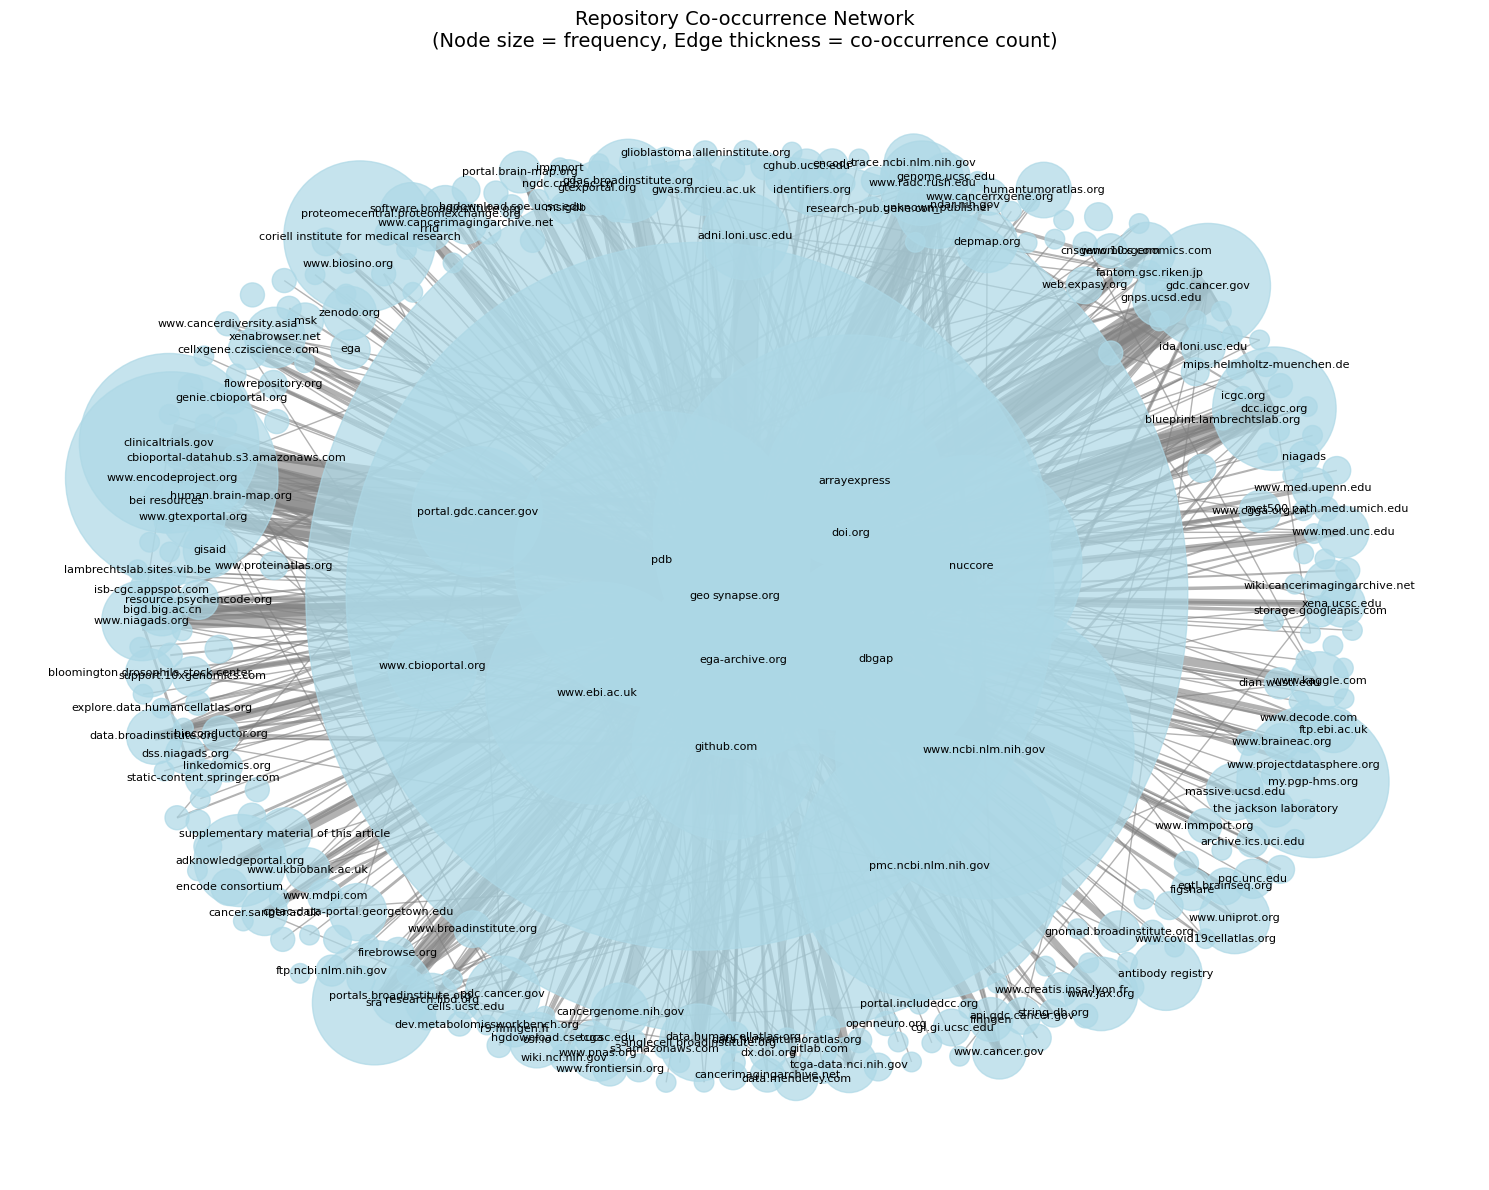


Network Statistics:
Number of repositories: 305
Number of co-occurrence relationships: 708
Average degree: 4.64

Most Connected Repositories (appear with many others):
  synapse.org: connected to 240 other repositories
  geo: connected to 101 other repositories
  doi.org: connected to 67 other repositories
  pdb: connected to 50 other repositories
  dbgap: connected to 48 other repositories
  www.ncbi.nlm.nih.gov: connected to 37 other repositories
  github.com: connected to 32 other repositories
  www.ebi.ac.uk: connected to 32 other repositories
  ega-archive.org: connected to 31 other repositories
  nuccore: connected to 25 other repositories


In [12]:
# Create a network visualization of repository co-occurrences
if cooccurrence_stats and cooccurrence_stats['frequent_pairs']:
    
    # Create network graph
    G = nx.Graph()
    
    # Add nodes (repositories)
    for repo, count in cooccurrence_stats['repo_counts'].items():
        if count >= 2:  # Only include repos that appear in at least 2 papers
            G.add_node(repo, size=count)
    
    # Add edges (co-occurrences)
    for (repo_a, repo_b), count in cooccurrence_stats['frequent_pairs'].items():
        if count >= 2:  # Only show pairs that co-occur at least 2 times
            G.add_edge(repo_a, repo_b, weight=count)
    
    print(f"Network created with {G.number_of_nodes()} repositories and {G.number_of_edges()} co-occurrence relationships")
    
    # Plot the network
    plt.figure(figsize=(15, 12))
    
    # Calculate layout
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Draw nodes
    node_sizes = [G.nodes[node].get('size', 1) * 100 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)
    
    # Draw edges
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[w/2 for w in edge_weights], alpha=0.6, edge_color='gray')
    
    # Draw labels (only for nodes with high degree or high frequency)
    high_degree_nodes = [node for node in G.nodes() if G.degree(node) >= 3 or G.nodes[node].get('size', 0) >= 5]
    labels = {node: node for node in high_degree_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Repository Co-occurrence Network\n(Node size = frequency, Edge thickness = co-occurrence count)", 
              fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print network statistics
    print("\nNetwork Statistics:")
    print(f"Number of repositories: {G.number_of_nodes()}")
    print(f"Number of co-occurrence relationships: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    
    # Find most connected repositories
    degree_centrality = nx.degree_centrality(G)
    top_connected = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print("\nMost Connected Repositories (appear with many others):")
    for repo, centrality in top_connected:
        print(f"  {repo}: connected to {G.degree(repo)} other repositories")

else:
    print("No co-occurrence data available for network visualization.")

In [13]:
# Install required package for network analysis if not already installed
try:
    import networkx as nx
except ImportError:
    print("Installing networkx for network analysis...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
    import networkx as nx

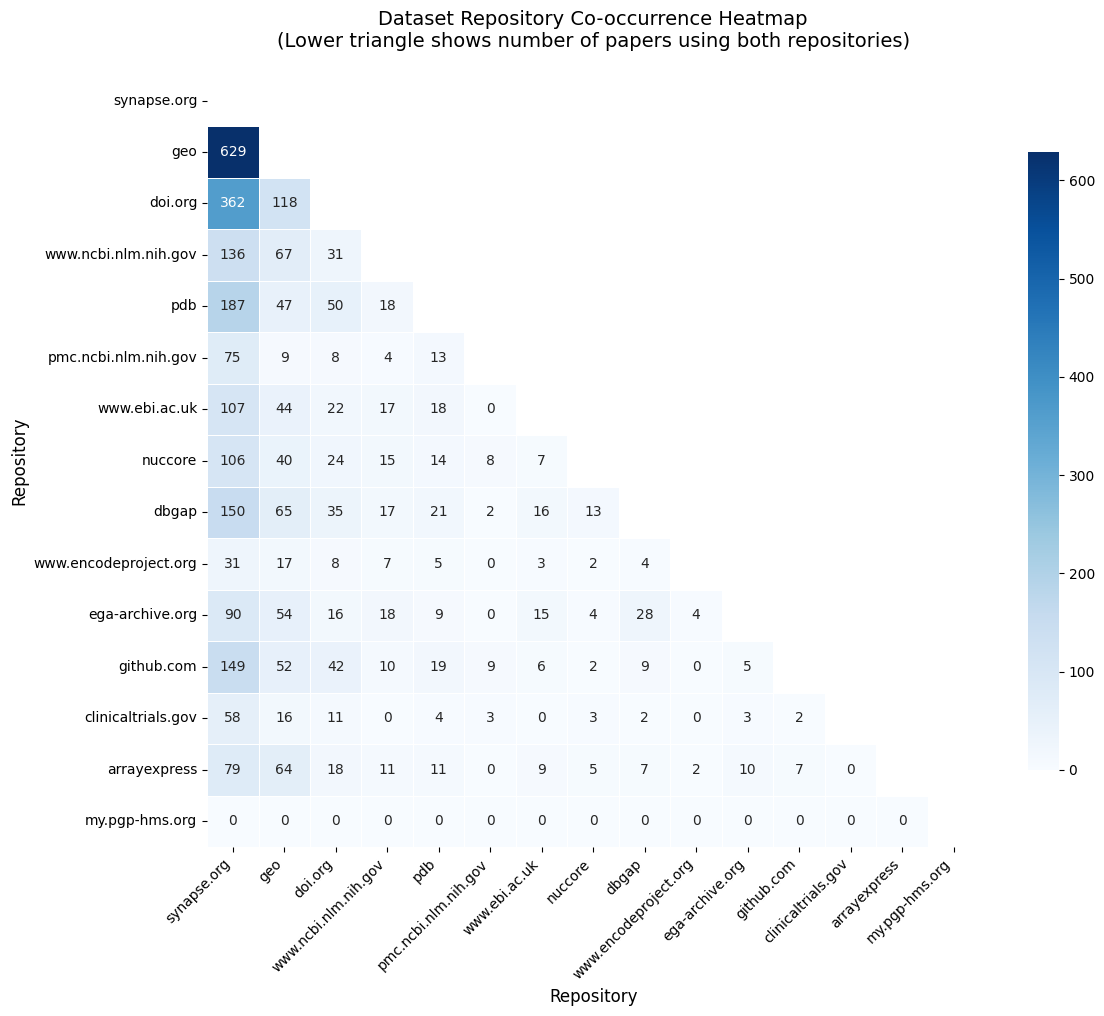


Top 15 Most Frequent Repositories:
 1. synapse.org: 4032 papers
 2. geo: 2597 papers
 3. doi.org: 812 papers
 4. www.ncbi.nlm.nih.gov: 463 papers
 5. pdb: 454 papers
 6. pmc.ncbi.nlm.nih.gov: 368 papers
 7. www.ebi.ac.uk: 256 papers
 8. nuccore: 255 papers
 9. dbgap: 242 papers
10. www.encodeproject.org: 234 papers
11. ega-archive.org: 206 papers
12. github.com: 180 papers
13. clinicaltrials.gov: 167 papers
14. arrayexpress: 162 papers
15. my.pgp-hms.org: 120 papers


In [14]:
# Create association rule heatmap for top repositories
if cooccurrence_stats and cooccurrence_stats['association_rules']:
    
    # Get top repositories by frequency
    top_repos = sorted(cooccurrence_stats['repo_counts'].items(), key=lambda x: x[1], reverse=True)[:15]
    top_repo_names = [repo for repo, count in top_repos]
    
    # Create a matrix of co-occurrence counts
    cooccurrence_matrix = pd.DataFrame(0, index=top_repo_names, columns=top_repo_names)
    
    for (repo_a, repo_b), count in cooccurrence_stats['frequent_pairs'].items():
        if repo_a in top_repo_names and repo_b in top_repo_names:
            cooccurrence_matrix.loc[repo_a, repo_b] = count
            cooccurrence_matrix.loc[repo_b, repo_a] = count  # Symmetric
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    import seaborn as sns
    
    # Create mask for upper triangle to avoid redundancy
    mask = np.triu(np.ones_like(cooccurrence_matrix, dtype=bool))
    
    sns.heatmap(cooccurrence_matrix, mask=mask, annot=True, fmt='d', cmap='Blues',
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Dataset Repository Co-occurrence Heatmap\n(Lower triangle shows number of papers using both repositories)', 
              fontsize=14, pad=20)
    plt.xlabel('Repository', fontsize=12)
    plt.ylabel('Repository', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 15 Most Frequent Repositories:")
    for i, (repo, count) in enumerate(top_repos[:15], 1):
        print(f"{i:2d}. {repo}: {count} papers")

else:
    print("No co-occurrence data available for heatmap visualization.")

## Summary of Association Rule Mining

The analysis above provides several key insights:

1. **Co-occurrence Analysis**: Identifies which datasets/repositories are frequently used together in the same research papers
2. **Association Rules**: Calculates confidence and lift metrics to understand the strength of relationships
3. **Network Visualization**: Shows the ecosystem of interconnected repositories
4. **Heatmap**: Provides a matrix view of co-occurrences for easy comparison

### Key Metrics Explained:

- **Support**: How often a repository appears across all papers
- **Confidence**: P(B|A) - If paper uses repository A, probability it also uses B
- **Lift**: Measures how much more likely repositories A and B are to appear together vs. independently
  - Lift > 1: Positive association (appear together more than expected)
  - Lift = 1: No association (independent)
  - Lift < 1: Negative association (appear together less than expected)

This analysis can help researchers discover:
- Related datasets they might want to consider
- Common data integration patterns in their field
- Repositories that are often used as complementary sources